In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
from sklearn.model_selection import KFold
import lightgbm as lgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")
test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv")
sub = pd.read_csv("/kaggle/input/bike-sharing-demand/sampleSubmission.csv")

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
sub.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


**EDA**

In [6]:
EDA_tr = train.copy()

In [7]:
EDA_tr.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [8]:
EDA_tr["date"] = EDA_tr.datetime.apply(lambda x : x.split()[0])
EDA_tr["hour"] = EDA_tr.datetime.apply(lambda x : x.split()[1].split(":")[0])
EDA_tr["weekday"] = EDA_tr.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
EDA_tr["month"] = EDA_tr.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
EDA_tr["season"] = EDA_tr.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
EDA_tr["weather"] = EDA_tr.weather.map({1: "Clear", 2 : "Mist", 3 : "Light Snow", 4 :"Heavy Rain" })
tEDA_tr  = EDA_tr.drop(["datetime"],axis=1)

In [9]:
EDA_tr.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,03,Saturday,January
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,04,Saturday,January


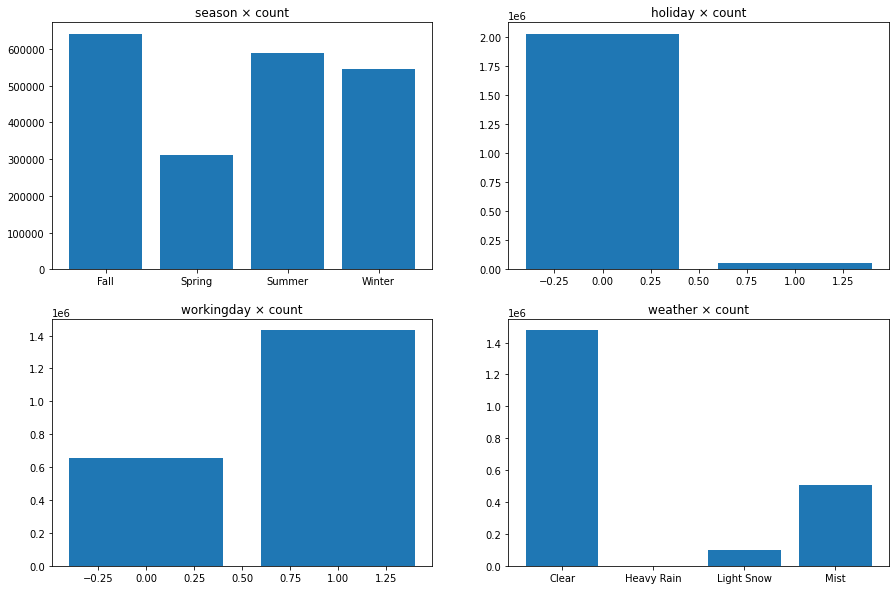

In [10]:
labels = ["season","holiday","workingday","weather"]
f,ax =  plt.subplots(2,2,figsize=(15,10))

for n,label in enumerate(labels):
    x = EDA_tr.groupby(label)["count"].sum().reset_index()[label]
    y = tEDA_tr.groupby(label)["count"].sum().reset_index()["count"]
    ax[n//2,n%2].bar(x,y)
    ax[n//2,n%2].set_title("{} × count".format(label))

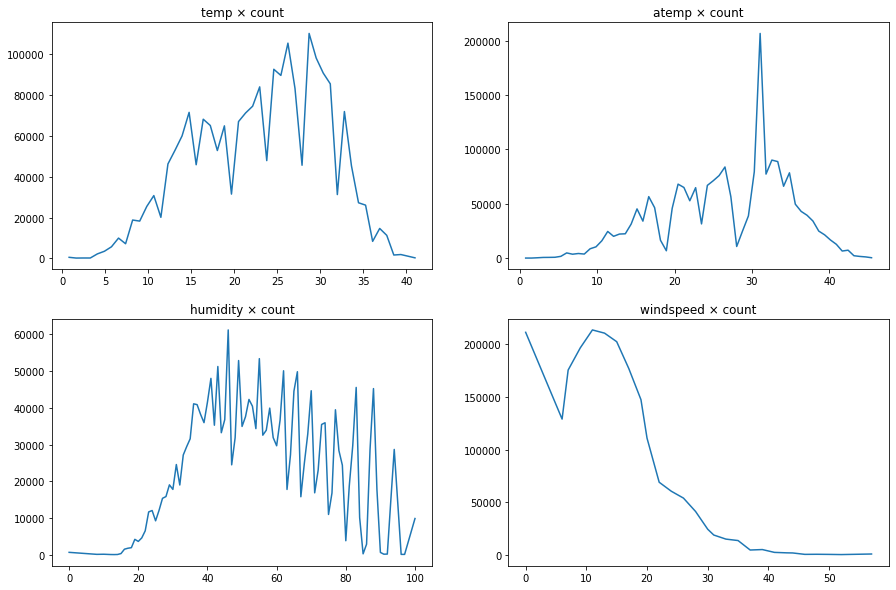

In [11]:
labels = ["temp","atemp","humidity","windspeed"]
f,ax =  plt.subplots(2,2,figsize=(15,10))

for n,label in enumerate(labels):
    x = EDA_tr.groupby(label)["count"].sum().reset_index()[label]
    y = EDA_tr.groupby(label)["count"].sum().reset_index()["count"]
    ax[n//2,n%2].plot(x,y)
    ax[n//2,n%2].set_title("{} × count".format(label))

<AxesSubplot:>

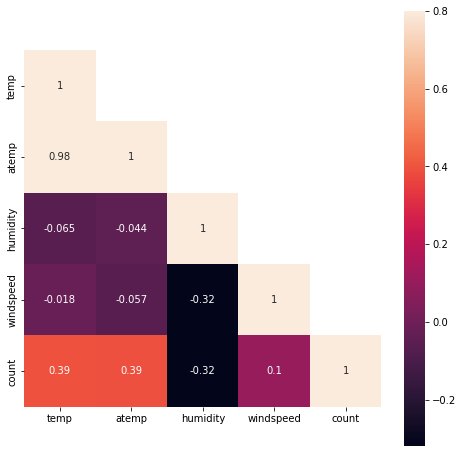

In [12]:
corrMatt = EDA_tr[["temp","atemp","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(8,8)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<AxesSubplot:xlabel='humidity', ylabel='count'>

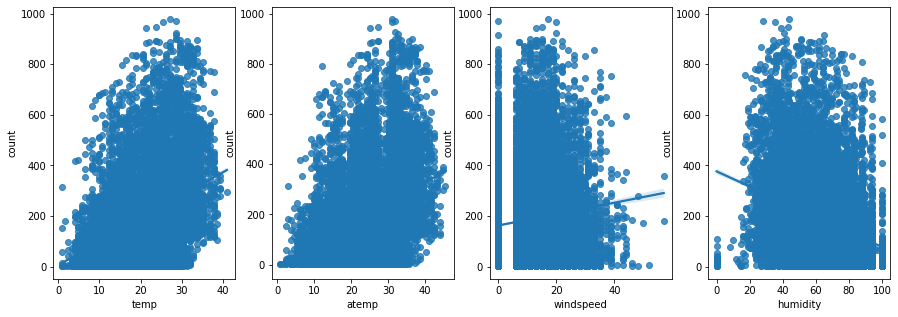

In [13]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
fig.set_size_inches(15, 5)
sns.regplot(x="temp", y="count", data=EDA_tr,ax=ax1)
sns.regplot(x="atemp", y="count", data=EDA_tr,ax=ax2)
sns.regplot(x="windspeed", y="count", data=EDA_tr,ax=ax3)
sns.regplot(x="humidity", y="count", data=EDA_tr,ax=ax4)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

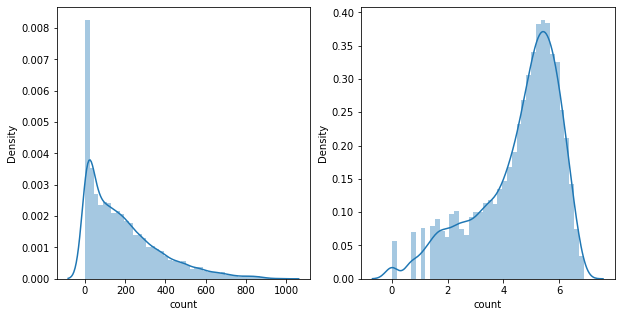

In [14]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10, 5)
sns.distplot(EDA_tr["count"],ax=ax1)
sns.distplot(np.log(EDA_tr["count"]),ax=ax2)

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Weekdays'),
 None]

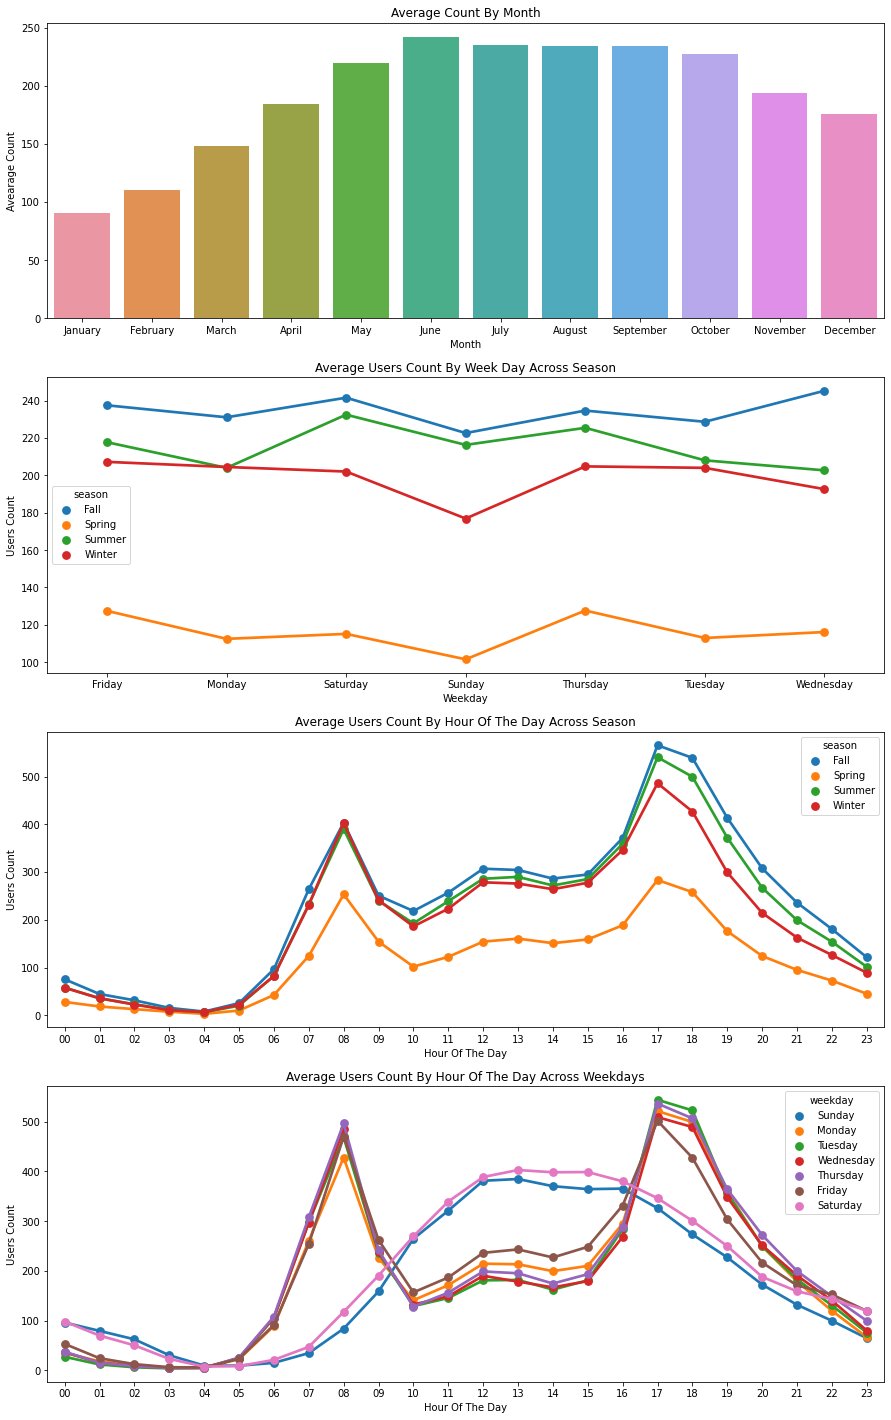

In [15]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(15,25)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(EDA_tr.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

weekdayAggregated = pd.DataFrame(EDA_tr.groupby(["weekday","season"])["count"].mean()).reset_index()
weekdaySorted  = weekdayAggregated.sort_values(by="count",ascending=False)
sns.pointplot(x=weekdayAggregated["weekday"], y=weekdayAggregated["count"],hue=weekdayAggregated["season"], data=weekdayAggregated, join=True,ax=ax2)
ax2.set(xlabel='Weekday', ylabel='Users Count',title="Average Users Count By Week Day Across Season",label='big')

hourAggregated = pd.DataFrame(EDA_tr.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(EDA_tr.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

**Feature engineering**

In [16]:
data = pd.concat([train,test])
data = data.reset_index()
data.drop("index",inplace=True,axis=1)

In [17]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [18]:
categorical_col = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numerical_col = ["temp","humidity","windspeed","atemp"]
drop_col = ["casual","count","date","datetime","registered"]

for col in categorical_col:
    data[col] = data[col].astype("category")

In [19]:
train = data[:len(train)]
test = data[len(train):]

In [20]:
y = train["count"]
X = train.drop(drop_col,axis=1)
test = test.drop(drop_col,axis=1)

In [21]:
print(X.shape)
print(y.shape)
print(test.shape)

(10886, 12)
(10886,)
(6493, 12)


**Model**

LightGBM

In [22]:
y = np.log1p(y)
y_pred = pd.DataFrame()
kf = KFold(n_splits=5,shuffle=True,random_state=1)

for fold,(tr_idx,val_idx) in enumerate(kf.split(X,y)):
    print("*****Fold {}*****".format(fold+1))
    tr_X,val_X = X.iloc[tr_idx],X.iloc[val_idx]
    tr_y,val_y = y.iloc[tr_idx],y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(tr_X,tr_y)
    lgb_eval = lgb.Dataset(val_X,val_y)

    params = {"objective" : "regression",
               "metric" : "rmse",
               'num_leaves': 200,
               'learning_rate': 0.1,
               'colsample_bytree': 0.9,
               'subsample': 0.8,
               'reg_alpha': 0.1,
              'random_state': 21}

    model = lgb.train(params,
                      lgb_train,
                      categorical_feature = categorical_col,
                      valid_names = ["train","valid"],
                      valid_sets = [lgb_train,lgb_eval],
                      num_boost_round = 10000,
                      early_stopping_rounds = 1,
                      verbose_eval = -1)

    pred = np.exp(model.predict(test))-1
    y_pred["fold{}".format(fold+1)] = pred 

*****Fold 1*****
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 12
[LightGBM] [Info] Start training from score 4.583961
Training until validation scores don't improve for 1 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['holiday', 'hour', 'month', 'season', 'weather', 'weekday', 'workingday', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

Early stopping, best iteration is:
[73]	train's rmse: 0.165682	valid's rmse: 0.307846
*****Fold 2*****
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 8709, number of used features: 12
[LightGBM] [Info] Start training from score 4.590259
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[63]	train's rmse: 0.181577	valid's rmse: 0.302094
*****Fold 3*****
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 8709, number of used features: 12
[LightGBM] [Info] Start training from

**Submission**

In [23]:
sub["count"] = y_pred.mean(axis=1)
sub.to_csv('submission', index=False)

In [24]:
sub

,datetime,count
0,2011-01-20 00:00:00,9.836509
1,2011-01-20 01:00:00,4.734405
2,2011-01-20 02:00:00,2.859063
3,2011-01-20 03:00:00,2.825150
4,2011-01-20 04:00:00,2.445319
...,...,...
6488,2012-12-31 19:00:00,275.597931
6489,2012-12-31 20:00:00,197.807564
6490,2012-12-31 21:00:00,147.379750
6491,2012-12-31 22:00:00,97.751752
